# Homework of Week 6

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import binom
from scipy.stats import norm
from scipy.stats import linregress
from scipy.special import comb

from time import perf_counter
from datetime import datetime

In [2]:
# Quantum Circuits!
import qiskit
from qiskit import QuantumCircuit
from qiskit import QuantumRegister, ClassicalRegister

print(f"Qiskit version {qiskit.__version__}")

# General Imports
from qiskit.primitives import StatevectorSampler
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Noisy simulations
from qiskit_aer import AerSimulator
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    depolarizing_error,
    pauli_error,
    thermal_relaxation_error,
)

# Running on a real quantum computer
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2

Qiskit version 1.3.2


# Exercise 1 - Random Number Generators (Uniform Distribution)

In [3]:
# Parameters

# Number of qubits
numq = 10

# Define number of shots
shots = 20000

In [4]:
# Circuit
qc = QuantumCircuit(numq)

# Make an equal superposition of all possible states
qc.h(list(range(numq)))

# Measure all qubits
qc.measure_all()

# View the circuit
qc.draw()

┌───┐ ░ ┌─┐                           
    q_0: ┤ H ├─░─┤M├───────────────────────────
         ├───┤ ░ └╥┘┌─┐                        
    q_1: ┤ H ├─░──╫─┤M├────────────────────────
         ├───┤ ░  ║ └╥┘┌─┐                     
    q_2: ┤ H ├─░──╫──╫─┤M├─────────────────────
         ├───┤ ░  ║  ║ └╥┘┌─┐                  
    q_3: ┤ H ├─░──╫──╫──╫─┤M├──────────────────
         ├───┤ ░  ║  ║  ║ └╥┘┌─┐               
    q_4: ┤ H ├─░──╫──╫──╫──╫─┤M├───────────────
         ├───┤ ░  ║  ║  ║  ║ └╥┘┌─┐            
    q_5: ┤ H ├─░──╫──╫──╫──╫──╫─┤M├────────────
         ├───┤ ░  ║  ║  ║  ║  ║ └╥┘┌─┐         
    q_6: ┤ H ├─░──╫──╫──╫──╫──╫──╫─┤M├─────────
         ├───┤ ░  ║  ║  ║  ║  ║  ║ └╥┘┌─┐      
    q_7: ┤ H ├─░──╫──╫──╫──╫──╫──╫──╫─┤M├──────
         ├───┤ ░  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐   
    q_8: ┤ H ├─░──╫──╫──╫──╫──╫──╫──╫──╫─┤M├───
         ├───┤ ░  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐
    q_9: ┤ H ├─░──╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├
         └───┘ ░  ║  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘
meas: 10/═════════╩══╩══╩══╩══╩══╩══╩══╩══╩══╩═
                  0  1  2  3  4  5  6  7  8  9

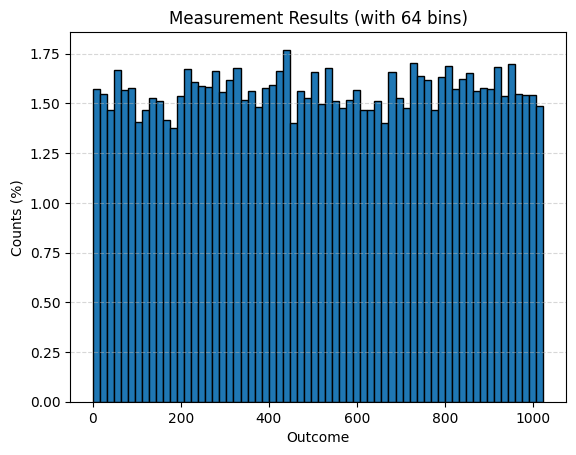

In [5]:
# Ideal Execution on Simulator
sim = AerSimulator()

# Run
job = sim.run(qc, shots=shots)
result = job.result()
counts = result.get_counts()

# Convert bin to dec
counts_dec = {int(res, 2): freq for res, freq in counts.items()}


def plot_counts(counts: dict, bin_size: int, label: str = "Sample") -> tuple[np.ndarray | list[np.ndarray], np.ndarray]:
    # Parse the data
    outcomes = np.array(list(counts.keys()))
    freqs = np.array(list(counts.values()))
    
    # Make the plot
    bins = len(set(outcomes)) // bin_size

    n, bin_edges, _ = plt.hist(outcomes, bins=bins, edgecolor='black', weights=freqs / shots * 100, label=label)
    plt.xlabel("Outcome")
    plt.ylabel("Counts (%)")
    plt.title(f"Measurement Results (with {bins} bins)")
    plt.grid(axis='y', linestyle='--', alpha=0.5)

    return n, bin_edges

_ = plot_counts(counts_dec, 16)

## Exercise 1.1 - Generating Distributions

In [6]:
# Limits of the distribution
mini = 2
maxi = 4

### Uniform Distribution

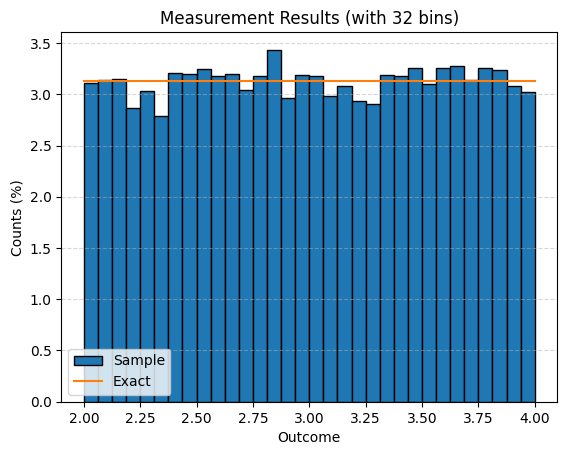

In [7]:
# Scale the counts within the limits
counts_maxi = max(counts_dec.keys())
counts_uni = {res / counts_maxi * (maxi - mini) + mini: freq for res, freq in counts_dec.items()}

# Plot
binning = 32
_ = plot_counts(counts_uni, binning)

# Plot exact distribution
plt.plot(np.linspace(mini, maxi, 1000), np.ones(1000) / (counts_maxi-1) * 100 * binning, label="Exact")
plt.legend()
plt.show()

### Binomial distribution

We can get the binomial distribution using a discrete inversion algorithm.

In [8]:
def isampling_discrete(cdf: np.ndarray, N: int) -> np.ndarray:
    """
    Given a cumulative probability function `c` assumed to be defined for events in {0, 1, ..., M-1},
    where M is some integer, returns `N` samples drawn from the corresponding distribution
    using the inverse transform sampling method for discrete distributions.
    """
    
    # Sample results
    results = np.empty(N)
    for i in range(N):
        a = np.random.rand()
        results[i] = sum(cdf < a)
    
    return results

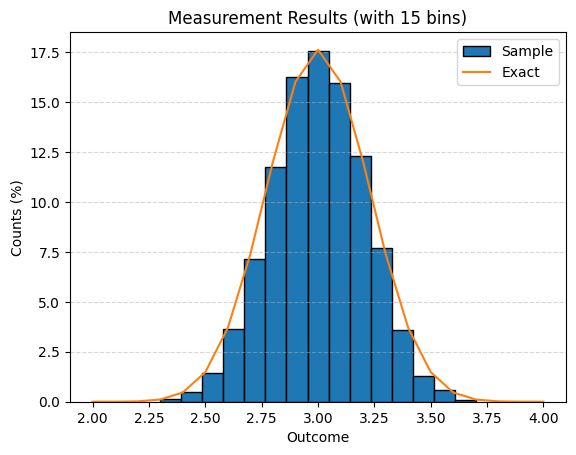

In [9]:
# Prepare the binomial cumulative distribution function
p = 0.5
n = 20
cdf = np.array([binom.cdf(index, n, p) for index in range(n+1)])
pmf = np.array([binom.pmf(index, n, p) for index in range(n+1)])

# Do the inversion algorithm (where the "random number" generated is the standard uniform distribution obtained from the quantum measurements)
counts_maxi = max(counts_dec.keys())
counts_bin = dict()
for res, freq in counts_dec.items():
    # Discard measurements of 0 and 1 which give an incorrect distribution
    if res == 0 or res == counts_maxi:
        continue

    index_bin = (np.sum(cdf < (res / counts_maxi)) / (len(cdf) - 1)) * (maxi - mini) + mini
    counts_bin[index_bin] = counts_bin.get(index_bin, 0) + freq

_ = plot_counts(counts_bin, 1)

# Plot exact distribution
plt.plot(np.linspace(mini, maxi, n+1), pmf * 100, label="Exact")
plt.legend()
plt.show()

### Normal distribution

We can get the normal distribution by a similar method, except we use the continuous version of the inversion algorithm.

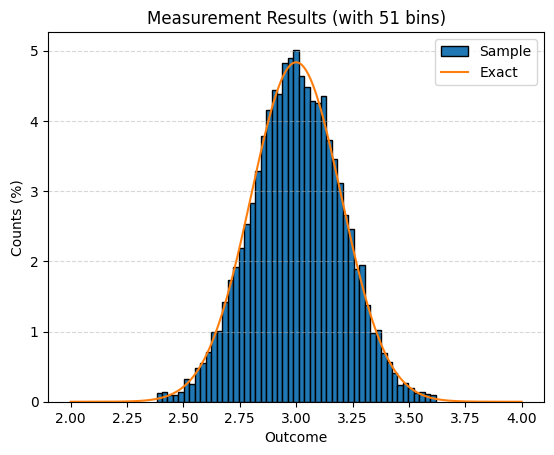

In [10]:
# Prepare the normal cumulative distribution function
mu = (maxi - mini) * 0.5
sigma = mu * 0.2
samples = 200
pdf = np.array([norm.pdf((maxi - mini) * (index / (samples - 1)), mu, sigma) for index in range(samples)])

# Do the inversion algorithm (where the "random number" generated is the standard uniform distribution obtained from the quantum measurements)
counts_maxi = max(counts_dec.keys())
counts_bin = dict()
for res, freq in counts_dec.items():
    # Discard measurements of 0 and 1 which give an incorrect distribution
    if res == 0 or res == counts_maxi:
        continue

    index_bin = norm.ppf(res / counts_maxi, mu, sigma) + mini
    counts_bin[index_bin] = counts_bin.get(index_bin, 0) + freq

n, bin_edges = plot_counts(counts_bin, 20)

# Normalize PDF
const = np.sum([(bin_edges[i + 1] - bin_edges[i]) * n[i] for i in range(len(n))])

# Plot exact distribution
plt.plot(np.linspace(mini, maxi, samples), pdf * const, label="Exact")
plt.legend()
plt.show()

## Exercise 1.2 - Running Time on Simulator

The circuit we are using only has single-qubit operations, hence we expect a **linear scalling** because doubling the number of qubits simply doubles the number of operations.

Slope: 0.016 | Intercept: 0.015 | r^2: 0.990


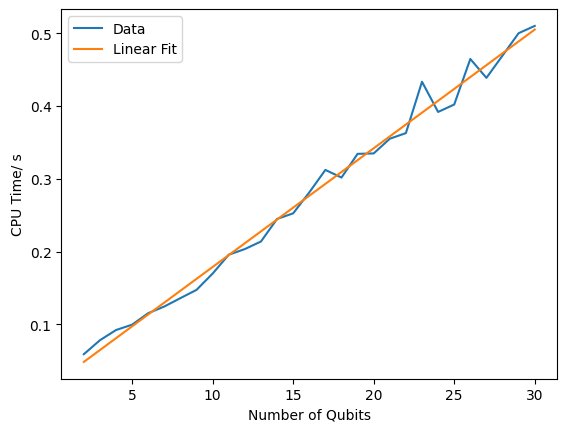

In [11]:
def qrng_sim(numq, shots=20000) -> dict:

    # Circuit
    qc = QuantumCircuit(numq)

    # Make an equal superposition of all possible states
    qc.h(list(range(numq)))

    # Measure all qubits
    qc.measure_all()

    # Simulate the circuit
    sim = AerSimulator()

    # Run
    job = sim.run(qc, shots=shots)
    result = job.result()
    counts = result.get_counts()

    # Return
    return counts


# Time the function
nn = np.arange(2, 31, 1)
tt = []
for numq in nn:
    start = perf_counter()
    counts = qrng_sim(numq)
    end = perf_counter()
    tt += [end - start]

# Linear Fit
slope, intercept, r_value, p_value, std_err = linregress(nn, tt)

print(f"Slope: {slope:.3f} | Intercept: {intercept:.3f} | r^2: {r_value**2:.3f}")

plt.plot(nn, tt, label="Data")
plt.plot(nn, slope * nn + intercept, label='Linear Fit')
plt.xlabel("Number of Qubits")
plt.ylabel("CPU Time/ s")
plt.legend()
plt.show()

## Exercise 1.3 - Running Time on Quantum Computer

In a quantum computer, all of the Hadamard gates can be performed simultaneously, hence we expect a constant-time result.

In [12]:
def qrng_real(numq, backend, shots=256) -> tuple[dict, float]:
    # Circuit
    qc = QuantumCircuit(numq)
    qc.h(list(range(numq)))
    qc.measure_all()

    # Transpile circuit
    pass_manager = generate_preset_pass_manager(backend=backend, optimization_level=1)
    tqc = pass_manager.run(qc)

    # Run job
    sampler = SamplerV2(backend)
    job = sampler.run([tqc], shots=shots)

    # Wait for results
    result = job.result()[0]

    # Extract job metadata (may include start/end times)
    metrics = job.metrics()

    # Parse ISO timestamps into datetime objects
    timestamps = metrics['timestamps']

    fmt = "%Y-%m-%dT%H:%M:%S.%fZ"
    t_running = datetime.strptime(timestamps['running'], fmt)
    t_finished = datetime.strptime(timestamps['finished'], fmt)

    # Compute precise durations
    run_time = (t_finished - t_running).total_seconds()

    counts = result.data.meas.get_counts()
    return counts, run_time


# Initiate connection
TOKEN = ""
service = QiskitRuntimeService(channel="ibm_quantum", token=TOKEN)

# Choose a real quantum computer, which is not busy
backend = service.least_busy(operational=True, simulator=False)
print(f"{backend.name =}, {backend.num_qubits = }")

# Time the function
nn = np.arange(2, 31, 2)
tt = []
for numq in nn:
    counts, time = qrng_real(numq, backend)
    tt += [time]

plt.plot(nn, tt, label="Data")
plt.plot(nn, np.ones_like(tt) * np.average(tt), label='Average')
plt.xlabel("Number of Qubits")
plt.ylabel("CPU Time/ s")
plt.legend()
plt.show()

AccountNotFoundError: 'Unable to find account.'

The predicted trend was observed, sadly when re-running this code before turning the work in the queue on IBM Quantum's resources was large, not allowing us to plot the graph.

# Exercise 1.4 - Commenting

As we mentioned in exercise 3, we can see that:
- In a simulated enviornment the scalling is linear, as we are only using single-qubit gates, whose outcome are computed in series.
- In an actual quantum computer the scalling is constant, those single qubit gates can be applyed in parallel, hence the time is independent of the number of qubits used.

# Exercise 2 - Random Number Generators (Any Distribution)

In [13]:
def qrng_sim_dist(coeffs: np.ndarray) -> dict:
    global shots
    
    # Infer number of qubits
    numq = int(np.log2(len(coeffs)))

    # Normalize the coefficients
    coeffs /= np.sqrt(np.sum(np.square(coeffs)))

    # Initialize the circuit
    qc = QuantumCircuit(numq)

    # Prepare the generic quantum state which gives the desired distribution
    qc.initialize(list(coeffs), range(numq))

    # Measure all qubits
    qc.measure_all()

    # Run the circuit on a simulator backend
    sim = AerSimulator()

    # Run
    job = sim.run(qc, shots=shots)
    result = job.result()
    counts = result.get_counts()
        
    # Convert bin to dec
    counts_dec = {int(res, 2): freq for res, freq in counts.items()}

    return counts_dec

### Uniform Distribution

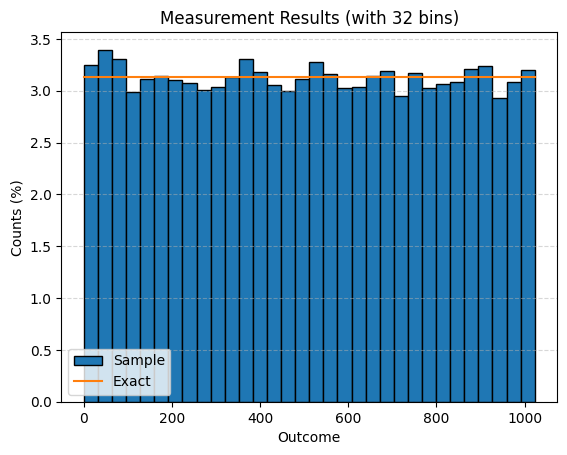

In [14]:
# Set the number of qubits
numq = 10

# Create the unormalized distribution
coeffs = np.ones(2**10)

# Generate random numbers
counts = qrng_sim_dist(coeffs)

# Plot
binning = 32
_ = plot_counts(counts, binning)

# Plot exact distribution
plt.plot(np.linspace(0, 2**numq - 1, 1000), np.ones(1000) / (2**numq-1) * 100 * binning, label="Exact")
plt.legend()
plt.show()

### Binomial Distribution

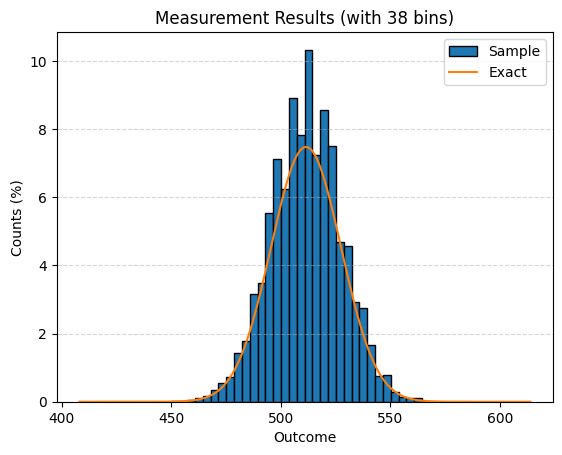

In [15]:
# Set the number of qubits
numq = 10

# Create the unormalized distribution
p = 0.5
coeffs = np.sqrt(np.array([binom.pmf(index, 2**numq - 1, p) for index in range(2**numq)]))

# Generate random numbers
counts = qrng_sim_dist(coeffs)

# Plot the counts
binning = 3
plot_counts(counts, binning)

# Plot exact distribution
plt.plot(np.arange(int(2**numq * 0.4)-1, int(2**numq * 0.6)+1), coeffs[int(2**numq * 0.4)-1: int(2**numq * 0.6)+1] ** 2 * 100 * binning, label="Exact")
plt.legend()
plt.show()

### Normal Distribution

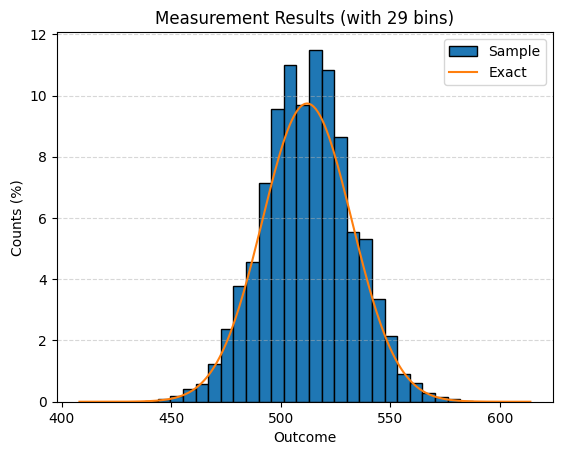

In [16]:
# Set the number of qubits
numq = 10

# Create the unormalized distribution
mu = 2**(numq-1)
sigma = mu * 0.04
coeffs = np.sqrt(np.array([norm.pdf(index, mu, sigma) for index in range(2**numq)]))

# Generate random numbers
counts = qrng_sim_dist(coeffs)

# Plot the counts
binning = 5
plot_counts(counts, binning)

# Plot exact distribution
plt.plot(np.arange(int(2**numq * 0.4)-1, int(2**numq * 0.6)+1), coeffs[int(2**numq * 0.4)-1: int(2**numq * 0.6)+1] ** 2 * 100 * binning, label="Exact")
plt.legend()
plt.show()

# Measurement Statistics and Quantum Fluctuations

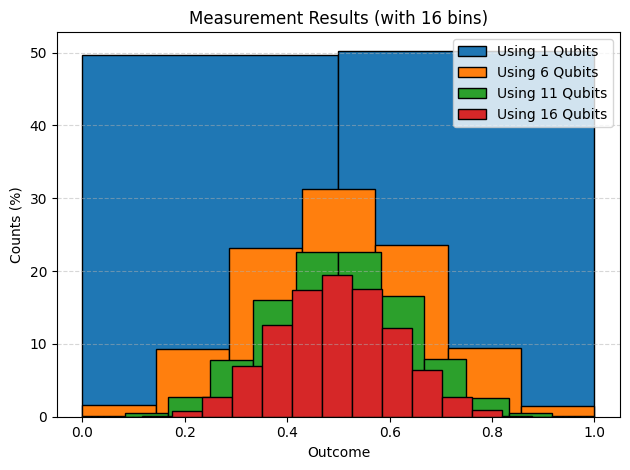

In [17]:
def sumstr(string: str) -> int:
    total = 0
    for digit in string:
        total += int(digit)
    return total


def qrng_sim_experiment(numq, shots=20000) -> dict:
    # Circuit
    qc = QuantumCircuit(numq)

    # Make an equal superposition of all possible states
    qc.h(list(range(numq)))

    # Measure all qubits
    qc.measure_all()

    # Simulate the circuit
    sim = AerSimulator()

    # Run
    job = sim.run(qc, shots=shots)
    result = job.result()
    counts = result.get_counts()

    # Convert keys to the desired number (we sum all the "1" in the bitstring of the outcome)
    counts_return = dict()
    for item in counts.items():
        key = sumstr(item[0]) / numq
        counts_return[key] = counts_return.get(key, 0) + item[1]
    
    return counts_return


# Run the experiment with a certain range of qubits
qq = np.array([1, 6, 11, 16])
for numq in qq:
    plot_counts(qrng_sim_experiment(numq), 1, f"Using {numq} Qubits")
    plt.tight_layout()
    plt.legend()

# Exercise 3 - Measurement Statistics

## Exercise 3.1 - Evolution of the Average

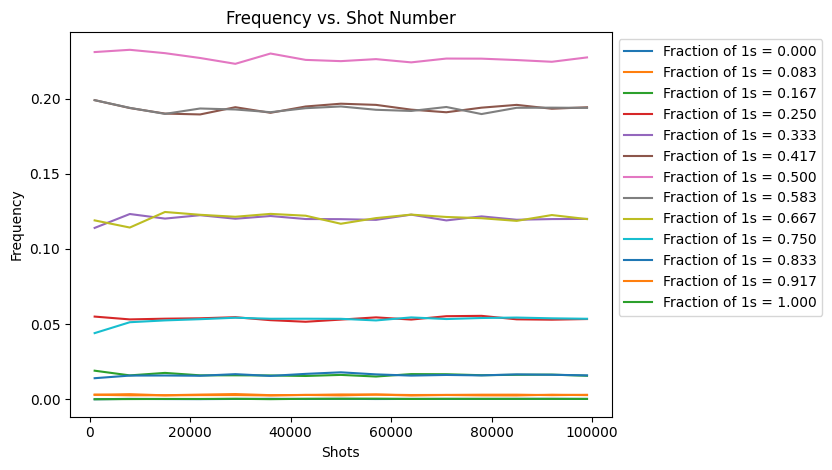

In [18]:
# Choose the number of qubits for which to do the experiment
numq = 12

# Choose the set of shot numbers that we will use
ss = np.arange(1000, 99000 + 1, 7000)

# Repeat the experiment for each shot number
results = {res / numq: [] for res in range(numq+1)}
for shots in ss:
    counts = qrng_sim_experiment(numq, shots)

    # Store the counts for each possible results as a function of the nubmer of shots
    for item in results.items():
        results[item[0]] += [counts.get(item[0], 0) / shots]


plt.title("Frequency vs. Shot Number")
for item in results.items():
    plt.plot(ss, item[1], label=f"Fraction of 1s = {item[0]:.3f}")

plt.xlabel("Shots")
plt.ylabel("Frequency")
plt.tight_layout()
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

## Exercise 3.2 - Evolution of the Standard Deviation

A random variable $\bar X$ which is the average of $n$ observations of $X$ will have a standard deviation given by:

$$
\sigma_{\bar X} = \frac{\sigma_X}{\sqrt{n}}
$$

Which in a log-log plot will translate to a linear relation:
$$
\log \sigma_{\bar X} = \log \sigma_X - \frac12 \log n
$$

In [19]:
# Choose the number of qubits for which to do the experiment
numq = 4

# Choose the set of shot numbers that we will use
ss = np.floor(np.e ** np.arange(3, 12))

# Choose how many times to repeat the experiment with a given number of shots
trials = 30

results = {res / numq: [] for res in range(numq+1)}
for shots in ss:
    results_temp = {res / numq: [] for res in range(numq+1)}

    # Repeat the experiment for each shot number
    for _ in range(trials):
        counts = qrng_sim_experiment(numq, shots)

        # Store the counts for each possible results as a function of the nubmer of shots
        for item in results_temp.items():
            results_temp[item[0]] += [counts.get(item[0], 0) / shots]
    
    # Store the std of the frequency for each possible outcome
    for item in results.items():
        results[item[0]] += [np.std(results_temp[item[0]])]


plt.title("Std of Frequency vs. Shot Number")
for item in results.items():
    color = plt.gca()._get_lines.get_next_color()  # Get next color in cycle

    plt.plot(np.log(ss), np.log(item[1]), label=f"Fraction of 1s = {item[0]:.3f}", color=color, linestyle='-')
    plt.plot(np.log(ss), -0.5 * np.log(ss) + (np.log(item[1])[0] + 0.5 * np.log(ss[0])), label=f"Predicted std for = {item[0]:.3f}", color=color, linestyle='--')

plt.xlabel("Log of Shots")
plt.ylabel("Log of Std of Frequency")
plt.tight_layout()
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

KeyboardInterrupt: 

# Quantum State Tomography

In [45]:
# This paper, section II B - https://arxiv.org/pdf/1407.4759
def inversion_physical(n0: list[int], n1: list[int]) -> np.ndarray:
    nx0, ny0, nz0 = n0
    nx1, ny1, nz1 = n1

    # Do the inversion
    rd = np.array([(nx0 - nx1) / (nx0 + nx1), (ny0 - ny1) / (ny0 + ny1), (nz0 - nz1) / (nz0 + nz1)])

    # We are only dealing with pure states, hence |Bloch vector| = 1
    rd = rd / np.linalg.norm(rd)
    
    return rd

In [46]:
# Reconstruct the state from the Bloch vector
def state_from_bloch(bloch: list) -> list:
    # Get angles
    theta = np.arccos(bloch[2])
    phi = np.arctan2(bloch[1], bloch[0])

    # Get the state
    a = np.cos(0.5 * theta)
    b = np.sin(0.5 * theta) * np.exp(1j * phi)

    return [a, b]

Function is working!


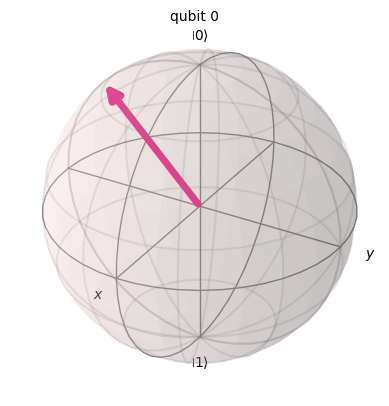

In [47]:
# Chose the state to be discriminated by the QST protocol
theta = 0.25 * np.pi
phi = 1.5 * np.pi

a = np.cos(0.5 * theta)
b = np.sin(0.5 * theta) * np.exp(1j * phi)

instate = [a, b]
invector = [np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)]

# Make sure our inversion function works
testbloch = state_from_bloch(invector)
if np.allclose(instate, testbloch):
    print("Function is working!")

plot_bloch_multivector(instate)

In [48]:
def qst_sim(instate: list, shots=1000) -> np.ndarray:
    
    # Create the QST circuit
    qc = QuantumCircuit(3)

    # Initialize all qubits in the same state
    for index in range(3):
        qc.initialize(instate, index)

    # Measure the qubits in different basis (X, Y, Z basis respectively)
    qc.h(0)
    qc.sdg(1)
    qc.h(1)
    qc.id(2)

    qc.measure_all()


    # Simulate the circuit
    sim = AerSimulator()

    # Run
    job = sim.run(qc, shots=shots)
    result = job.result()
    counts = result.get_counts()

    # Parse the output according to direction
    n0 = [0, 0, 0]
    n1 = [0, 0, 0]
    for item in counts.items():
        string, freq = item
        string = string[::-1]
        for index, result in enumerate(string):
            if int(result) == 0:
                n0[index] += freq
            else:
                n1[index] += freq
    
    return inversion_physical(n0, n1)

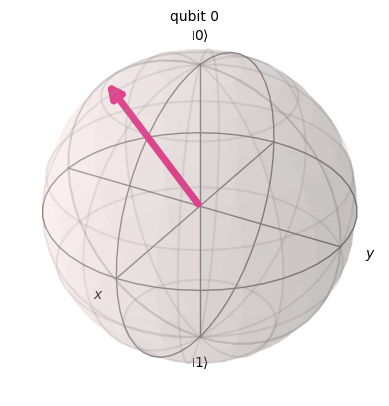

In [49]:
# Test the protocol
outvector = qst_sim(instate)
plot_bloch_multivector(state_from_bloch(outvector))

Text(0, 0.5, 'Distance in Bloch space')

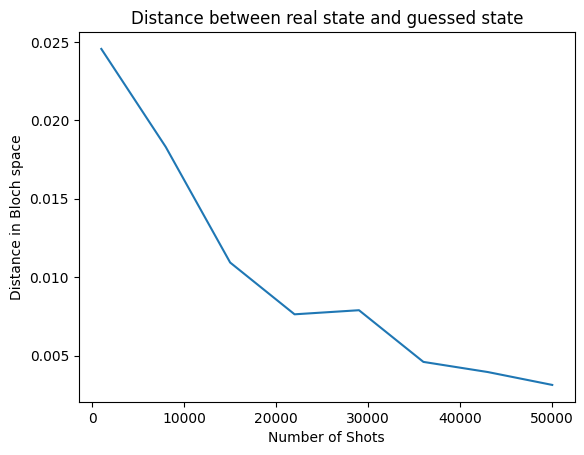

In [50]:
# Measure distance between instate and outstate as a function of number of shots
ss = np.arange(1000, 50000 + 1, 7000)
dd = []
for shots in ss:
    outvector = qst_sim(instate, shots)
    dd += [np.linalg.norm(outvector - invector)]

plt.plot(ss, dd)
plt.title("Distance between real state and guessed state")
plt.xlabel("Number of Shots")
plt.ylabel("Distance in Bloch space")

# Exercise 6 - Test for many states

In [ ]:
# We can test for a set number of states
nums = 10
shots = 30000
for _ in range(nums):
    invector = np.random.rand(3)
    invector /= np.linalg.norm(invector)

    instate = state_from_bloch(list(invector))
    outvector = qst_sim(instate, shots)

    print(f"Distance in Bloch space: {np.linalg.norm(outvector - invector):.5f}")

Distance in Bloch space: 0.00383
Distance in Bloch space: 0.00321
Distance in Bloch space: 0.00795
Distance in Bloch space: 0.00122
Distance in Bloch space: 0.00684
Distance in Bloch space: 0.00595
Distance in Bloch space: 0.00845
Distance in Bloch space: 0.00666
Distance in Bloch space: 0.00507
Distance in Bloch space: 0.00083


# Exercise 7 - Mixed States

We won't fully solve the exercise, but in principle we only need to do two things:
- Use a purification method to embed the mixed state into our pure-state based circuit.
- Remove the purification constraint on the inversion step (detailed below).

In [ ]:
# This paper, section II B - https://arxiv.org/pdf/1407.4759
def inversion_physical(n0: list[int], n1: list[int]) -> np.ndarray:
    nx0, ny0, nz0 = n0
    nx1, ny1, nz1 = n1

    # Do the inversion
    rd = np.array([(nx0 - nx1) / (nx0 + nx1), (ny0 - ny1) / (ny0 + ny1), (nz0 - nz1) / (nz0 + nz1)])
    if (norm := np.linalg.norm(rd)) > 1:
        rd /= norm
    
    return rd